In [1]:
import sys
sys.path.append('../../TF-coursera/')

from vlimit import *
vram_limit()

2022-09-04 11:58:49.261067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 11:58:49.273954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 11:58:49.274644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# # Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-09-04 12:05:59--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.138.128, 142.251.45.80, 142.251.32.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.138.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M  24.2MB/s    in 3.7s    

2022-09-04 12:06:03 (22.5 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

2022-09-04 12:06:46.883637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-04 12:06:46.884538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 12:06:46.885097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 12:06:46.885511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Planning on use up to mixed_7 as base model because my intended last layer might be too specialized in what it has learned, and it might not translate well into the application.
However, mixed_7 will be more generalized and it's good for the start of the application.

In [7]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Adding Dense layer for classifier

In [9]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [10]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

#### Prepare dataset

In [11]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Extract the archive
# zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
# zip_ref.extractall("tmp/")
# zip_ref.close()

# Define our example directories and files
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Train the Model

In [12]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20


2022-09-04 12:33:08.119492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-09-04 12:33:08.556856: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-04 12:33:09.245905: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 - 11s - loss: 0.3489 - accuracy: 0.8580 - val_loss: 0.2697 - val_accuracy: 0.9080 - 11s/epoch - 113ms/step
Epoch 2/20
100/100 - 6s - loss: 0.2241 - accuracy: 0.9135 - val_loss: 0.2212 - val_accuracy: 0.9190 - 6s/epoch - 62ms/step
Epoch 3/20
100/100 - 6s - loss: 0.1759 - accuracy: 0.9320 - val_loss: 0.1998 - val_accuracy: 0.9330 - 6s/epoch - 61ms/step
Epoch 4/20
100/100 - 6s - loss: 0.1691 - accuracy: 0.9390 - val_loss: 0.1065 - val_accuracy: 0.9650 - 6s/epoch - 61ms/step
Epoch 5/20
100/100 - 6s - loss: 0.1955 - accuracy: 0.9330 - val_loss: 0.1610 - val_accuracy: 0.9540 - 6s/epoch - 60ms/step
Epoch 6/20
100/100 - 6s - loss: 0.1820 - accuracy: 0.9400 - val_loss: 0.1102 - val_accuracy: 0.9630 - 6s/epoch - 60ms/step
Epoch 7/20
100/100 - 6s - loss: 0.1789 - accuracy: 0.9415 - val_loss: 0.1124 - val_accuracy: 0.9690 - 6s/epoch - 60ms/step
Epoch 8/20
100/100 - 6s - loss: 0.1672 - accuracy: 0.9425 - val_loss: 0.3939 - val_accuracy: 0.9000 - 6s/epoch - 60ms/step
Epoch 9/20
100/100 - 6s 

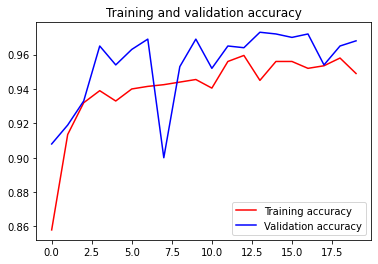

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()